In [15]:
#Installing Wandb library
!pip install wandb

In [ ]:
# Downloading and setting up dataset

!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip
!rm nature_12K.zip

!mv ./inaturalist_12K/val ./inaturalist_12K/test

--2022-04-02 15:40:57--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  53.8MB/s    in 69s     

2022-04-02 15:42:05 (53.0 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]

Archive:  nature_12K.zip
replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# !rm -rf inaturalist_12K

In [4]:
# Mounting Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Logging into wandb
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **Imports**

In [6]:
#Importing Libraries

import os
import pathlib

#wandb Imports
import wandb
from wandb.keras import WandbCallback

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Activation, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential, Model

#Importing Pre-Trained models from Keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception

In [7]:
# Declaring some global variables

IMG_SIZE = (224,224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 6

BASE_MODELS = {
                  "IRV2" : InceptionResNetV2,
                  "IV3" : InceptionV3,
                  "RN50" : ResNet50,
                  "XCPTN" : Xception
              } 

In [ ]:
# Initializing WANDB sweep configurations

sweep_config = {
  "method": "bayes",
  "metric":{
  "name": "val_accuracy",
  "goal": "maximize"
  },
  "parameters": {
        "data_augmentation": {
            "values": [ True, False]
        },
        "base_model": {
            "values": [ "XCPTN", "IV3", "RN50", "IRV2"]
        },
        "dense_neurons": {
            "values": [ 128, 256]
        },
        "optimizer": {
            "values": [ "nadam","adam","rmsprop"]
        },
        "dropout": {
            "values": [ 0.2, 0.3, 0.5]
        },
        "trainable_ratio": {
            "values": [0.25, 0.33, 0.5, 1]
        }
              
    }
}

In [8]:
#Setting numpy seed for consistency and reproducibility of results

np.random.seed(1)

In [9]:
# Function for generating training, validation and test data from the dataset

def dataGen(data_augmentation, image_dimensions, batch_size):
    if data_augmentation == True:
            # Data augmentation 
            train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255,             # Rescales the data by multiplying it with the value provided
                validation_split = 0.1,     # Reserves a fraction of image for validation
                shear_range=0.2,       
                zoom_range=0.2, 
                rotation_range=15,          # Augment data by rotating the image 
                width_shift_range=0.1,      # Augment data by shifting the image horizontally
                height_shift_range=0.1,     # Augment data by shifting the image vertically
                horizontal_flip=True        # Augment data by flipping the image
            )
    else:
        train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.1)

    test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = train_data_generator.flow_from_directory(
        './inaturalist_12K/train',
        subset='training',
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True,
        seed = 2)
            
    validation_generator = train_data_generator.flow_from_directory(
        './inaturalist_12K/train',
        target_size=image_dimensions,
        subset = 'validation',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True,
        seed = 1)


                
    test_generator = test_data_generator.flow_from_directory(
        './inaturalist_12K/test',
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True,
        seed = 1)

    return train_generator, validation_generator, test_generator

In [ ]:
# Function to build and train the model with wandb

def train():
    wandb.init(project = 'PartB1', config = sweep_config ,entity='cs21m007_cs21m013')
    CONFIG = wandb.config

    data_augmentation = CONFIG.data_augmentation
    
    # Getting the Training, Validation and Test data from the dataset
    train_generator, validation_generator, test_generator = dataGen(data_augmentation, IMG_SIZE, BATCH_SIZE)
    
    # Building the structure of our Model

    tf.keras.backend.clear_session()
    pretrained_model = BASE_MODELS[CONFIG.base_model]
    base = pretrained_model(weights='imagenet', include_top=False) #Add here
    # base.trainable = False
    inputs = keras.Input(shape=(224, 224, 3))
    X = base(inputs, training=False)
    X = GlobalAveragePooling2D()(X)
    X = keras.layers.Dropout(CONFIG.dropout)(X)
    X = Dense(CONFIG.dense_neurons, activation='sigmoid')(X)
    X = keras.layers.Dropout(CONFIG.dropout)(X)
    predictions = Dense(NUM_CLASSES, activation='softmax')(X)
    model = Model(inputs = inputs, outputs=predictions)

    #Freezing all the layers of our base model
    for layer in base.layers:
        layer.trainable = False

    model.summary()

    # for l in model.layers:
    #     print(l.name, l.trainable)

    model.compile(optimizer=CONFIG.optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    # Training the last 2 fully connected layers of our model
    history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS
    )
    
    #base.trainable = True

    sizeOfBase = len(base.layers)
    print("Size of our re-trained model = ", sizeOfBase)
    f_ratio = CONFIG.trainable_ratio
    numOfTrainable = int(f_ratio*sizeOfBase)

    print("Numer of trainable Layers", numOfTrainable)

    for i in range(sizeOfBase-1, sizeOfBase - numOfTrainable, -1):
        base.layers[i].trainable = True
    
    # model.layers[n].trainable = False
    # base.trainable = True
    # for l in model.layers:
    #     print(l.name, l.trainable)

    model.summary()



    model.compile(optimizer=CONFIG.optimizer(1e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy']) #optimizer=tf.keras.optimizers.Adam(1e-5)

    # Fine tuning our transfer learning model
    history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // BATCH_SIZE,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // BATCH_SIZE,
        epochs = EPOCHS, 
        callbacks=[WandbCallback()]
        )

In [ ]:
sweep_id = wandb.sweep(sweep_config,project='PartB1', entity='cs21m007_cs21m013')
wandb.agent(sweep_id, train, count = 10)

# train()

Create sweep with ID: s88etp37
Sweep URL: https://wandb.ai/cs21m0007/Try/sweeps/s88etp37


wandb: Agent Starting Run: 8dj1defl with config:
wandb: 	base_model: XCPTN
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.5
wandb: 	optimizer: adam
wandb: 	trainable_ratio: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    


accuracy,▁▃▅▆▇█
epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
val_accuracy,▁▅▆▄▄█
val_loss,█▃▄▁▅▇
accuracy,0.88704
best_epoch,3
best_val_loss,0.65716
epoch,5
loss,0.35505
val_accuracy,0.78327


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 43oi48jl with config:
wandb: 	base_model: XCPTN
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.2
wandb: 	optimizer: adam
wandb: 	trainable_ratio: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 

# **Training the best model**

In [10]:
# Building the model with best parameters from sweeps


best_config = dict(
                dense_neurons = 256 ,
                trainable_ratio = 0.5,
                num_classes = 10,
                optimizer = 'nadam',
                base_model = "IRV2",
                data_augmentation = False,
                dropout = 0.3,
            )

wandb.init(project = 'TestingBestModel', config = best_config ,entity='cs21m007_cs21m013')
CONFIG = wandb.config

data_augmentation = CONFIG.data_augmentation


# Getting the Training, Validation and Test data from the dataset
train_generator, validation_generator, test_generator = dataGen(data_augmentation, IMG_SIZE, BATCH_SIZE)

# Building the structure of our Model

tf.keras.backend.clear_session()
pretrained_model = BASE_MODELS[CONFIG.base_model]
base = pretrained_model(weights='imagenet', include_top=False) #Add here
# base.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
X = base(inputs, training=False)
X = GlobalAveragePooling2D()(X)
X = keras.layers.Dropout(CONFIG.dropout)(X)
X = Dense(CONFIG.dense_neurons, activation='sigmoid')(X)
X = keras.layers.Dropout(CONFIG.dropout)(X)
predictions = Dense(NUM_CLASSES, activation='softmax')(X)
model = Model(inputs = inputs, outputs=predictions)

#Freezing all the layers of our base model
for layer in base.layers:
    layer.trainable = False

model.summary()

# for l in model.layers:
#     print(l.name, l.trainable)

model.compile(optimizer=CONFIG.optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Training the last 2 fully connected layers of our model
history = model.fit(
train_generator,
steps_per_epoch = train_generator.samples // BATCH_SIZE,
validation_data = validation_generator, 
validation_steps = validation_generator.samples // BATCH_SIZE,
epochs = EPOCHS
)

#base.trainable = True

sizeOfBase = len(base.layers)
print("Size of our re-trained model = ", sizeOfBase)
f_ratio = CONFIG.trainable_ratio
numOfTrainable = int(f_ratio*sizeOfBase)

print("Numer of trainable Layers", numOfTrainable)

for i in range(sizeOfBase-1, sizeOfBase - numOfTrainable, -1):
    base.layers[i].trainable = True


model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Fine tuning our transfer learning model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS, 
    callbacks=[WandbCallback()]
    )

model.save('./TrainedModel/')
wandb.finish()

wandb: Currently logged in as: cs21m007_cs21m013 (use `wandb login --relogin` to force relogin)


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
219070464/219055592 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                

accuracy,▁▄▆▇██
epoch,▁▂▄▅▇█
loss,█▅▄▂▁▁
val_accuracy,▃▆█▅▁▇
val_loss,▂▁▂▄▇█
accuracy,0.98874
best_epoch,1
best_val_loss,0.56801
epoch,5
loss,0.05515
val_accuracy,0.81048


In [12]:
#Evaluating the best model
wandb.init(project = 'TestingBestModel', config = best_config ,entity='cs21m007_cs21m013')
model.evaluate(test_generator, batch_size = 32, callbacks=[WandbCallback()])

63/63 [==============================] - 30s 476ms/step - loss: 0.7939 - accuracy: 0.7950


[0.793941080570221, 0.7950000166893005]

In [14]:
# Copying model from temporary runtime storage to drive 
!cp -rf /content/TrainedModel/ /content/drive/MyDrive/

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


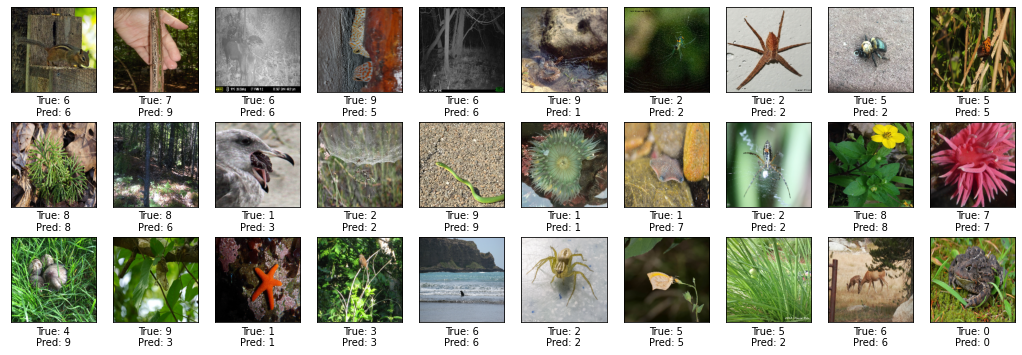

In [14]:
#To let the gpu memory utilisiation grow as per requirement
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass
# The dimensions of our input image
img_width,img_height = 224, 224
# Batch size
batch_size=32
wandb.init(project = 'TestingBestModel', entity='cs21m007_cs21m013')
# Load the test data
train_generator, validation_generator, test_generator = dataGen(False, IMG_SIZE, BATCH_SIZE)

#Model trained from scratch
source_model = keras.models.load_model('/content/drive/MyDrive/TrainedModel') #Load the best trained model


# Sample image predictions
ROWS = 3
COLUMNS = 10 
ix = 1 
fig,ax = plt.subplots(ROWS,COLUMNS,figsize=(6*ROWS,6))
for i in range(ROWS): 
    for j in range(COLUMNS): 
        # Creating the subplots for the sample images
        idx = np.random.choice(len(test_generator[4*j][0])) 
        img = test_generator[4*j][0][idx] 
        ax = plt.subplot(ROWS, COLUMNS, ix)

        ax.set_xticks([]) 
        ax.set_yticks([])
        # Creating the images of the subplots 
        plt.imshow(img) 
        plt.xlabel(
                    "True: " + str(np.argmax(test_generator[4*j][1][idx])) +"\n" + "Pred: " + 
                    str(np.argmax(source_model.predict(img.reshape(1,224,224,3))))
                   )
        ix += 1 
# Save the images
#plt.savefig(save_plots+"sample_prediction")
wandb.log({"sample_prediction": plt})
plt.show()